In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152

from torchvision.models import ResNet18_Weights, ResNet34_Weights, ResNet50_Weights, ResNet101_Weights, ResNet152_Weights

base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# RESNET FIRST PASSES THROUGH HERE

In [ ]:
"""Base Model for Semantic Segmentation"""

import torch.nn as nn

__all__ = ['SegBaseModel']

class SegBaseModel(nn.Module):
    """Base Model for Semantic Segmentation
    Parameters
    ----------
    backbone : string
        Pre-trained dilated backbone network type (default:'resnet50'; 'resnet50',
        'resnet101' or 'resnet152').
    """

    def __init__(self, nclass, backbone='resnet50', pretrained_base=True, **kwargs):
        super(SegBaseModel, self).__init__()
        dilated = True # Not used.
        self.nclass = nclass
        if backbone == 'resnet18':
          self.pretrained = base_model
        elif backbone == 'resnet34':
          self.pretrained = base_model
        elif backbone == 'resnet50':
          self.pretrained = base_model
        elif backbone == 'resnet101':
          self.pretrained = base_model
        elif backbone == 'resnet152':
          self.pretrained = base_model
        else:
            raise RuntimeError('unknown backbone: {}'.format(backbone))

    def base_forward(self, x):
        """forwarding pre-trained network"""
        x = self.pretrained.conv1(x)
        x = self.pretrained.bn1(x)
        x = self.pretrained.relu(x)
        x = self.pretrained.maxpool(x)
        c1 = self.pretrained.layer1(x)
        c2 = self.pretrained.layer2(c1)
        c3 = self.pretrained.layer3(c2)
        c4 = self.pretrained.layer4(c3)
        
        return c1, c2, c3, c4

    def evaluate(self, x):
        """evaluating network with inputs and targets"""
        return self.forward(x)[0]

    def demo(self, x):
        pred = self.forward(x)
        return pred

# ICNET MODEL

In [ ]:
"""Image Cascade Network"""
import torch
import torch.nn as nn
import torch.nn.functional as F

#from .segbase import SegBaseModel
from torchsummary import summary

__all__ = ['ICNet', 'get_icnet', 'get_icnet_resnet50_citys',
           'get_icnet_resnet101_citys', 'get_icnet_resnet152_citys']

class ICNet(SegBaseModel):
    """Image Cascade Network"""
    
    def __init__(self, nclass = 19, backbone='resnet50', pretrained_base=True):
        super(ICNet, self).__init__(nclass,backbone, pretrained_base=pretrained_base)
        self.conv_sub1 = nn.Sequential(
            _ConvBNReLU(3, 32, 3, 2),#_ConvBNReLU(3, 128, 3, 2),  #in,out,kernel_size,stride
            _ConvBNReLU(32, 32, 3, 2),#_ConvBNReLU(128, 128, 3, 2),
            _ConvBNReLU(32, 64, 3, 2)#_ConvBNReLU(128, 64, 3, 2)
        )
        
        self.ppm = PyramidPoolingModule()

        self.head = _ICHead(nclass, backbone)

        self.__setattr__('exclusive', ['conv_sub1', 'head'])
        
    def forward(self, x):
        # sub 1
        x_sub1 = self.conv_sub1(x)

        # sub 2
        x_sub2 = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=True) # scale_factor = 0.5
        _, x_sub2, _, _ = self.base_forward(x_sub2)
        
        # sub 4
        x_sub4 = F.interpolate(x, scale_factor=0.25, mode='bilinear', align_corners=True) # scale_factor = 0.25
        _, _, _, x_sub4 = self.base_forward(x_sub4)
        # add PyramidPoolingModule
        x_sub4 = self.ppm(x_sub4)
        
        outputs = self.head(x_sub1, x_sub2, x_sub4)



        
        return tuple(outputs)

class PyramidPoolingModule(nn.Module):
	def __init__(self, pyramids=[1,2,3,6]):
		super(PyramidPoolingModule, self).__init__()
		self.pyramids = pyramids

	def forward(self, input):
		feat = input
		height, width = input.shape[2:]
		for bin_size in self.pyramids:
			x = F.adaptive_avg_pool2d(input, output_size=bin_size)
			x = F.interpolate(x, size=(height, width), mode='bilinear', align_corners=True)
			feat  = feat + x
		return feat
    
class _ICHead(nn.Module):
    def __init__(self, nclass, backbone='resnet50', norm_layer=nn.BatchNorm2d, **kwargs):
        super(_ICHead, self).__init__()
        if backbone == 'resnet18':
          #self.cff_12 = CascadeFeatureFusion(128, 64, 128, nclass, norm_layer, **kwargs) # For ResNet-50 and bigger
          self.cff_12 = CascadeFeatureFusion(128, 64, 128, nclass, norm_layer, **kwargs) # For ResNet-34 and smaller 
          #                               cff_24:out/xsub1:in/cff_12:out
          #self.cff_24 = CascadeFeatureFusion(2048, 512, 128, nclass, norm_layer, **kwargs) # For ResNet-50 and bigger
          self.cff_24 = CascadeFeatureFusion(512, 128, 128, nclass, norm_layer, **kwargs) # For ResNet-34 and smaller
          #                               xsub4:in/xsub2:in/cff_24:out
          #                               512, 128, 128, ...
        elif backbone == 'resnet34':
          self.cff_12 = CascadeFeatureFusion(128, 64, 128, nclass, norm_layer, **kwargs)
          self.cff_24 = CascadeFeatureFusion(512, 128, 128, nclass, norm_layer, **kwargs)
        elif backbone == 'resnet50':
          self.cff_12 = CascadeFeatureFusion(128, 64, 128, nclass, norm_layer, **kwargs)
          self.cff_24 = CascadeFeatureFusion(2048, 512, 128, nclass, norm_layer, **kwargs)
        elif backbone == 'resnet101':
          self.cff_12 = CascadeFeatureFusion(128, 64, 128, nclass, norm_layer, **kwargs)
          self.cff_24 = CascadeFeatureFusion(2048, 512, 128, nclass, norm_layer, **kwargs)
        elif backbone == 'resnet152':
          self.cff_12 = CascadeFeatureFusion(128, 64, 128, nclass, norm_layer, **kwargs)
          self.cff_24 = CascadeFeatureFusion(2048, 512, 128, nclass, norm_layer, **kwargs)
        
        self.conv_cls = nn.Conv2d(128, nclass, 1, bias=False)

    def forward(self, x_sub1, x_sub2, x_sub4):
        outputs = list()
        x_cff_24, x_24_cls = self.cff_24(x_sub4, x_sub2)
        outputs.append(x_24_cls)
        # x_cff_12, x_12_cls = self.cff_12(x_sub2, x_sub1)
        x_cff_12, x_12_cls = self.cff_12(x_cff_24, x_sub1)
        outputs.append(x_12_cls)

        up_x2 = F.interpolate(x_cff_12, scale_factor=2, mode='bilinear', align_corners=True) # scale_factor = 2
        up_x2 = self.conv_cls(up_x2)
        outputs.append(up_x2)
        up_x8 = F.interpolate(up_x2, scale_factor=4, mode='bilinear', align_corners=True) # scale_factor = 4
        outputs.append(up_x8)
        # 1 -> 1/4 -> 1/8 -> 1/16
        outputs.reverse()

        return outputs


class _ConvBNReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1,
                 groups=1, norm_layer=nn.BatchNorm2d, bias=False, **kwargs):
        super(_ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.bn = norm_layer(out_channels)
        self.relu = nn.ReLU(True)#self.relu = nn.GELU()#self.relu = nn.LeakyReLU(0.05)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class CascadeFeatureFusion(nn.Module):
    """CFF Unit"""

    def __init__(self, low_channels, high_channels, out_channels, nclass, norm_layer=nn.BatchNorm2d, **kwargs):
        super(CascadeFeatureFusion, self).__init__()
        self.conv_low = nn.Sequential(
            nn.Conv2d(low_channels, out_channels, 3, padding=2, dilation=2, bias=False),
            norm_layer(out_channels)
        )
        self.conv_high = nn.Sequential(
            nn.Conv2d(high_channels, out_channels, 1, bias=False),
            norm_layer(out_channels)
        )
        self.conv_low_cls = nn.Conv2d(out_channels, nclass, 1, bias=False)

    def forward(self, x_low, x_high):
        x_low = F.interpolate(x_low, size=x_high.size()[2:], mode='bilinear', align_corners=True)
        x_low = self.conv_low(x_low)

        x_high = self.conv_high(x_high)
        x = x_low + x_high
        x = F.relu(x, inplace=True)#x = F.gelu(x)#x = F.leaky_relu(x, 0.05,inplace=True)
        x_low_cls = self.conv_low_cls(x_low)

        return x, x_low_cls

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved.
import logging
import os
import sys

__all__ = ['SetupLogger']

# reference from: https://github.com/facebookresearch/maskrcnn-benchmark/blob/master/maskrcnn_benchmark/utils/logger.py
def SetupLogger(name, save_dir, distributed_rank, filename="log.txt", mode='w'):
    logger = logging.getLogger(name)
    logger.setLevel(logging.DEBUG)
    # don't log results for the non-master process
    if distributed_rank > 0:
        return logger
    ch = logging.StreamHandler(stream=sys.stdout)
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter("%(asctime)s %(name)s %(levelname)s: %(message)s")
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        fh = logging.FileHandler(os.path.join(save_dir, filename), mode=mode)  # 'a+' for add, 'w' for overwrite
        fh.setLevel(logging.DEBUG)
        fh.setFormatter(formatter)
        logger.addHandler(fh)

    return 

# TRAIN 

In [ ]:
import os
import time
import datetime
import yaml
import torch
import torch.nn as nn
import torch.utils.data as data

#from dataset import CityscapesDataset
#from models import ICNet
#from utils import ICNetLoss, IterationPolyLR, SegmentationMetric, SetupLogger

class Trainer(object):
    def __init__(self, cfg, load = False, loadPath = None):
        #self.logger = logger
        self.cfg = cfg
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.dataparallel = torch.cuda.device_count() > 1
        self.losses = []
        self.IoU_list = []
        
        # dataset and dataloader
        train_dataset = CityscapesDataset(root = cfg["train"]["cityscapes_root"], 
                                          split='train', 
                                          base_size=cfg["model"]["base_size"], 
                                          crop_size=cfg["model"]["crop_size"])
        val_dataset = CityscapesDataset(root = cfg["train"]["cityscapes_root"], 
                                        split='val',
                                        base_size=cfg["model"]["base_size"], 
                                        crop_size=cfg["model"]["crop_size"])
        self.train_dataloader = data.DataLoader(dataset=train_dataset,
                                                batch_size=cfg["train"]["train_batch_size"],
                                                shuffle=True,
                                                num_workers=4,
                                                pin_memory=True,
                                                drop_last=False)
        self.val_dataloader = data.DataLoader(dataset=val_dataset,
                                              batch_size=cfg["train"]["valid_batch_size"],
                                              shuffle=False,
                                              num_workers=4,
                                              pin_memory=True,
                                              drop_last=False)
        
        self.iters_per_epoch = len(self.train_dataloader)
        self.max_iters = cfg["train"]["epochs"] * self.iters_per_epoch

        # create network
        self.model = ICNet(nclass = train_dataset.NUM_CLASS, backbone='resnet50').to(self.device) # Backbone choice made here.
        
        # create criterion
        self.criterion = ICNetLoss(ignore_index=train_dataset.IGNORE_INDEX).to(self.device)
        
        # optimizer, for model just includes pretrained, head and auxlayer
        params_list = list()
        if hasattr(self.model, 'pretrained'):
            params_list.append({'params': self.model.pretrained.parameters(), 'lr': cfg["optimizer"]["init_lr"]})
        if hasattr(self.model, 'exclusive'):
            for module in self.model.exclusive:
                params_list.append({'params': getattr(self.model, module).parameters(), 'lr': cfg["optimizer"]["init_lr"] * 10})
        # Base optimizer.
        self.optimizer = torch.optim.SGD(params = self.model.parameters(),
                                          lr = cfg["optimizer"]["init_lr"],
                                          momentum=cfg["optimizer"]["momentum"],
                                          weight_decay=cfg["optimizer"]["weight_decay"])
        
        # AdamW optimizer.
        #self.optimizer = torch.optim.AdamW(params = params_list, 
        #                                   lr = 1e-2,
        #                                   betas = (0.9, 0.999),
        #                                   eps = 1e-8,
        #                                   weight_decay = 1e-2)

        # Base optimizer.
        # self.optimizer = torch.optim.SGD(params = self.model.parameters(),
        #                                  lr = cfg["optimizer"]["init_lr"],
        #                                  momentum=cfg["optimizer"]["momentum"],
        #                                  weight_decay=cfg["optimizer"]["weight_decay"])
        
        # LambdaLR scheduler.
        #schedule_fn = lambda epoch: 0.95 ** epoch
        #self.lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=schedule_fn)
        
        # base lr scheduler
        self.lr_scheduler = IterationPolyLR(self.optimizer,
                                            max_iters=self.max_iters,
                                            power=0.9)
        
        # dataparallel
        if(self.dataparallel):
             self.model = nn.DataParallel(self.model)

        # evaluation metrics
        self.metric = SegmentationMetric(train_dataset.NUM_CLASS)

        self.current_mIoU = 0.0
        self.best_mIoU = 0.0
        
        self.epochs = cfg["train"]["epochs"]
        self.current_epoch = 0
        self.current_iteration = 0

        if load == True:
          checkpoint = torch.load(load_path) ###### TODO ######
          self.model.load_state_dict(checkpoint['model_state_dict'])
          self.optimizer.load_state_dict(checkpoint['optim_state_dict'])
          self.current_epoch = checkpoint['current_epoch']
        
    def train(self):
        epochs, max_iters = self.epochs, self.max_iters
        log_per_iters = self.cfg["train"]["log_iter"]
        val_per_iters = self.cfg["train"]["val_epoch"] * self.iters_per_epoch
        
        start_time = time.time()
        print('Start training, Total Epochs: {:d} = Total Iterations {:d}'.format(epochs, max_iters))
        #logger.info('Start training, Total Epochs: {:d} = Total Iterations {:d}'.format(epochs, max_iters))
        
        self.model.train()
        
        for _ in range(self.epochs): 
            self.current_epoch += 1
            lsit_pixAcc = []
            list_mIoU = []
            list_loss = []
            self.metric.reset()
            for i, (images, targets, _) in enumerate(self.train_dataloader):  
                self.current_iteration += 1
                
                self.lr_scheduler.step() # Use this for the base lr scheduler.

                images = images.to(self.device)
                targets = targets.to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)
		
                self.metric.update(outputs[0], targets)
                pixAcc, mIoU = self.metric.get()
                lsit_pixAcc.append(pixAcc)
                list_mIoU.append(mIoU)
                list_loss.append(loss.item())

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                eta_seconds = ((time.time() - start_time) / self.current_iteration) * (max_iters - self.current_iteration)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                
                if self.current_iteration % log_per_iters == 0:
                  print("Epochs: {:d}/{:d} || Iters: {:d}/{:d} || Lr: {:.6f} || Train Loss: {:.4f} || mIoU: {:.4f} || Cost Time: {} || Estimated Time: {}".format(
                            self.current_epoch, self.epochs, 
                            self.current_iteration, max_iters, 
                            self.optimizer.param_groups[0]['lr'], 
                            loss.item(), 
                            mIoU,
                            str(datetime.timedelta(seconds=int(time.time() - start_time))), 
                            eta_string))
                    #logger.info(
                     #   "Epochs: {:d}/{:d} || Iters: {:d}/{:d} || Lr: {:.6f} || Loss: {:.4f} || mIoU: {:.4f} || Cost Time: {} || Estimated Time: {}".format(
                      #      self.current_epoch, self.epochs, 
                       #     self.current_iteration, max_iters, 
                        #    self.optimizer.param_groups[0]['lr'], 
                         #   loss.item(), 
                          #  mIoU,
                           # str(datetime.timedelta(seconds=int(time.time() - start_time))), 
                            #eta_string))
		
            #self.lr_scheduler.step() # Use this for the lr schedulers which changes with epoch.

            average_pixAcc = sum(lsit_pixAcc)/len(lsit_pixAcc)
            average_mIoU = sum(list_mIoU)/len(list_mIoU)
            average_loss = sum(list_loss)/len(list_loss)
            self.losses.append(average_loss)
            self.IoU_list.append(average_mIoU)
            print("Epochs: {:d}/{:d}, Average loss: {:.3f}, Average mIoU: {:.3f}, Average pixAcc: {:.3f}".format(self.current_epoch, self.epochs, average_loss, average_mIoU, average_pixAcc))
            #logger.info("Epochs: {:d}/{:d}, Average loss: {:.3f}, Average mIoU: {:.3f}, Average pixAcc: {:.3f}".format(self.current_epoch, self.epochs, average_loss, average_mIoU, average_pixAcc))
		
            if self.current_iteration % val_per_iters == 0:
                self.validation()
                self.model.train()

        total_training_time = time.time() - start_time
        total_training_str = str(datetime.timedelta(seconds=total_training_time))
        print("Total training time: {} ({:.4f}s / it)".format(
            total_training_str, total_training_time / max_iters))
        #logger.info(
         #   "Total training time: {} ({:.4f}s / it)".format(
          #  total_training_str, total_training_time / max_iters))
        return self.model

    def validation(self):
        is_best = False
        self.metric.reset()
        if self.dataparallel:
            model = self.model.module
        else:
            model = self.model
        model.eval()
        lsit_pixAcc = []
        list_mIoU = []
        list_loss = []
        for i, (image, targets, filename) in enumerate(self.val_dataloader):
            image = image.to(self.device)
            targets = targets.to(self.device)
            
            with torch.no_grad():
                outputs = model(image)
                loss = self.criterion(outputs, targets)
            self.metric.update(outputs[0], targets)
            pixAcc, mIoU = self.metric.get()
            lsit_pixAcc.append(pixAcc)
            list_mIoU.append(mIoU)
            list_loss.append(loss.item())

        average_pixAcc = sum(lsit_pixAcc)/len(lsit_pixAcc)
        average_mIoU = sum(list_mIoU)/len(list_mIoU)
        average_loss = sum(list_loss)/len(list_loss)
        self.current_mIoU = average_mIoU
        print("Validation: Average loss: {:.3f}, Average mIoU: {:.3f}, Average pixAcc: {:.3f}".format(average_loss,  average_mIoU, average_pixAcc))
        #self.logger.info("Validation: Average loss: {:.3f}, Average mIoU: {:.3f}, Average pixAcc: {:.3f}".format(average_loss,  average_mIoU, average_pixAcc))

        save_checkpoint(self, self.model, self.optimizer, average_mIoU, average_loss, self.cfg, self.current_epoch, is_best, self.current_mIoU, self.dataparallel)
        
        #if self.current_mIoU > self.best_mIoU:
        #    is_best = True
        #    self.best_mIoU = self.current_mIoU
        #if is_best:
           # save_checkpoint(self.model, self.optimizer, self.losses, self.cfg, self.current_epoch, is_best, self.current_mIoU, self.dataparallel)

def save_checkpoint(trainer, model, optimizer, valid_mIoU, valid_loss, cfg, epoch = 0, is_best=False, mIoU = 0.0, dataparallel = False):
    """Save Checkpoint"""
    directory = os.path.expanduser(cfg["train"]["ckpt_dir"])
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = '{}_{}_{}_{:.3f}.pth'.format(cfg["model"]["name"], cfg["model"]["backbone"],epoch,mIoU)
    filename = os.path.join(directory, filename)
    if dataparallel:
        model = model.module
    #if is_best:
    best_filename = '{}_{}_{}_{:.3f}_best_model.pth'.format(cfg["model"]["name"], cfg["model"]["backbone"],epoch,mIoU)
    best_filename = os.path.join(directory, best_filename)
    torch.save(
        {
            'model_state_dict': model.state_dict(), 
            'optim_state_dict': optimizer.state_dict(),
            'current_epoch': epoch,
            'valid_loss': valid_loss,
            'valid_mIoU': valid_mIoU,
            'train_loss': trainer.losses[-1],
            'train_mIoU': trainer.IoU_list[-1]
        }, best_filename)
    save_to_drive(best_filename)
        

#if __name__ == '__main__':
def main(load = False, path = None):
    # Set config file
    config_path = "./icnet.yaml"
    with open(config_path, "r") as yaml_file:
        cfg = yaml.full_load(yaml_file.read())
        #print(cfg)
        #print(cfg["model"]["backbone"])
        #print(cfg["train"]["specific_gpu_num"])
    
    # Use specific GPU
    os.environ["CUDA_VISIBLE_DEVICES"] = str(cfg["train"]["specific_gpu_num"])
    num_gpus = len(cfg["train"]["specific_gpu_num"].split(','))
    print("torch.cuda.is_available(): {}".format(torch.cuda.is_available()))
    print("torch.cuda.device_count(): {}".format(torch.cuda.device_count()))
    print("torch.cuda.current_device(): {}".format(torch.cuda.current_device()))

    # Set logger
    #logger = SetupLogger(name = "semantic_segmentation", 
     #                     save_dir = cfg["train"]["ckpt_dir"], 
      #                    distributed_rank = 0,
       #                   filename='{}_{}_log.txt'.format(cfg["model"]["name"], cfg["model"]["backbone"]))
    #logger.info("Using {} GPUs".format(num_gpus))
    #logger.info("torch.cuda.is_available(): {}".format(torch.cuda.is_available()))
    #logger.info("torch.cuda.device_count(): {}".format(torch.cuda.device_count()))
    #logger.info("torch.cuda.current_device(): {}".format(torch.cuda.current_device()))
    #logger.info(cfg)
    
    # Start train
    trainer = Trainer(cfg, load, path) # trainer = Trainer(cfg,logger)
    model = trainer.train()
    return model

# RUN THE MODEL

In [ ]:
load = False
load_path = "/content/drive/MyDrive/multiclass-seg/icnet-scale1-30k/icnet_resnet50_71_0.642_best_model.pth"

model = main(load, load_path)

torch.cuda.is_available(): True
torch.cuda.device_count(): 1
torch.cuda.current_device(): 0
Found 2975 images in the folder /content/drive/MyDrive/multiclass-seg/cityscapes/leftImg8bit/train
Found 500 images in the folder /content/drive/MyDrive/multiclass-seg/cityscapes/leftImg8bit/val
Start training, Total Epochs: 20 = Total Iterations 8500
Epochs: 1/20 || Iters: 10/8500 || Lr: 0.010000 || Train Loss: 1.5219 || mIoU: 0.1498 || Cost Time: 0:00:05 || Estimated Time: 1:20:03
Epochs: 1/20 || Iters: 20/8500 || Lr: 0.010000 || Train Loss: 1.4440 || mIoU: 0.1734 || Cost Time: 0:00:09 || Estimated Time: 1:05:04
Epochs: 1/20 || Iters: 30/8500 || Lr: 0.010000 || Train Loss: 1.1151 || mIoU: 0.1946 || Cost Time: 0:00:13 || Estimated Time: 1:04:02
Epochs: 1/20 || Iters: 40/8500 || Lr: 0.010000 || Train Loss: 0.9602 || mIoU: 0.2046 || Cost Time: 0:00:17 || Estimated Time: 1:00:02
Epochs: 1/20 || Iters: 50/8500 || Lr: 0.010000 || Train Loss: 1.1924 || mIoU: 0.2198 || Cost Time: 0:00:21 || Estimated 

# PLOT THE LOSSES AND SCORES

In [ ]:
import os
import matplotlib.pyplot as plt


def plot_losses():

    path = "/content/drive/MyDrive/multiclass-seg/icnet-scale1-base-20Epoch" # CHANGE THIS PER MODEL

    train_losses = []
    val_losses = []
    train_mIoUs = []
    val_mIoUs = []

    for item in os.listdir(path):
      checkpoint = torch.load(path + "/" + item)
      train_loss = checkpoint['train_loss']
      train_mIoU = checkpoint['train_mIoU']
      valid_loss = checkpoint['valid_loss']
      valid_mIoU = checkpoint['valid_mIoU']
      train_losses.append(train_loss)
      val_losses.append(valid_loss)
      train_mIoUs.append(train_mIoU)
      val_mIoUs.append(valid_mIoU)

    epoch_list = checkpoint['current_epoch']
    epoch_list = list(range(epoch_list))

    plt.plot(epoch_list, train_losses, color='blue', label = "train")
    plt.plot(epoch_list, val_losses, color='red', label = "test")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss over 20 epochs")
    plt.show()

    print()

    plt.plot(epoch_list, train_mIoUs, color='green', label = "train")
    plt.plot(epoch_list, val_mIoUs, color='purple', label = "test")
    plt.xlabel('Epochs')
    plt.ylabel('mIoU')
    plt.legend()
    plt.title("mIoU over 20 epochs")
    plt.show()


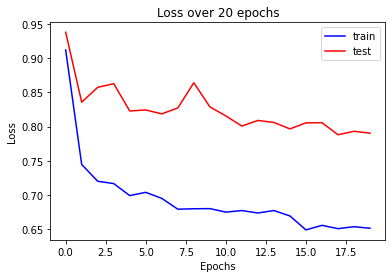

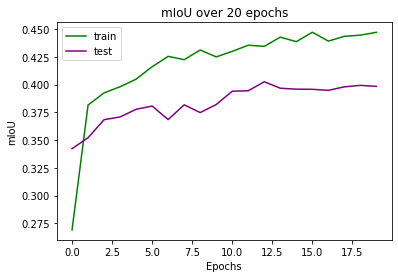

In [ ]:
plot_losses()

In [ ]:
import shutil

def save_to_drive(source_path):
  #print(source_path)
  shutil.copy(source_path,"/content/drive/MyDrive/multiclass-seg/icnet-scale1-base-20Epoch")

In [ ]:
torch.cuda.device_count()

1

In [ ]:
"""Custom losses."""
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

__all__ = ['ICNetLoss']

# TODO: optim function
class ICNetLoss(nn.CrossEntropyLoss):
    """Cross Entropy Loss for ICNet"""
    
    def __init__(self, aux_weight=0.4, ignore_index=-1):
        super(ICNetLoss, self).__init__(ignore_index=ignore_index)
        self.aux_weight = aux_weight

    def forward(self, *inputs):
        preds, target = tuple(inputs)
        inputs = tuple(list(preds) + [target])

        pred, pred_sub4, pred_sub8, pred_sub16, target = tuple(inputs)
        # [batch, H, W] -> [batch, 1, H, W]
        target = target.unsqueeze(1).float()
        target_sub4 = F.interpolate(target, pred_sub4.size()[2:], mode='bilinear', align_corners=True).squeeze(1).long()
        target_sub8 = F.interpolate(target, pred_sub8.size()[2:], mode='bilinear', align_corners=True).squeeze(1).long()
        target_sub16 = F.interpolate(target, pred_sub16.size()[2:], mode='bilinear', align_corners=True).squeeze(
            1).long()
        loss1 = super(ICNetLoss, self).forward(pred_sub4, target_sub4)
        loss2 = super(ICNetLoss, self).forward(pred_sub8, target_sub8)
        loss3 = super(ICNetLoss, self).forward(pred_sub16, target_sub16)
        #return dict(loss=loss1 + loss2 * self.aux_weight + loss3 * self.aux_weight)
        return loss1 + loss2 * self.aux_weight + loss3 * self.aux_weight

In [ ]:
"""Popular Learning Rate Schedulers"""
from __future__ import division
import math
import torch

from bisect import bisect_right

__all__ = ['IterationPolyLR']

class IterationPolyLR(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, target_lr=0, max_iters=0, power=0.9, last_epoch=-1):
        self.target_lr = target_lr
        self.max_iters = max_iters
        self.power = power
        super(IterationPolyLR, self).__init__(optimizer, last_epoch)
        
    def get_lr(self):
        N = self.max_iters 
        T = self.last_epoch
        factor = pow(1 - T / N, self.power)
        # https://blog.csdn.net/mieleizhi0522/article/details/83113824
        return [self.target_lr + (base_lr - self.target_lr) * factor for base_lr in self.base_lrs]

In [ ]:
"""Evaluation Metrics for Semantic Segmentation"""
import torch
import numpy as np

__all__ = ['SegmentationMetric', 'batch_pix_accuracy', 'batch_intersection_union',
           'pixelAccuracy', 'intersectionAndUnion', 'hist_info', 'compute_score']


class SegmentationMetric(object):
    """Computes pixAcc and mIoU metric scores
    """

    def __init__(self, nclass):
        super(SegmentationMetric, self).__init__()
        self.nclass = nclass
        self.reset()

    def update(self, preds, labels):
        """Updates the internal evaluation result.
        Parameters
        ----------
        labels : 'NumpyArray' or list of `NumpyArray`
            The labels of the data.
        preds : 'NumpyArray' or list of `NumpyArray`
            Predicted values.
        """

        def evaluate_worker(self, pred, label):
            correct, labeled = batch_pix_accuracy(pred, label)
            inter, union = batch_intersection_union(pred, label, self.nclass)

            self.total_correct += correct
            self.total_label += labeled
            if self.total_inter.device != inter.device:
                self.total_inter = self.total_inter.to(inter.device)
                self.total_union = self.total_union.to(union.device)
            self.total_inter += inter
            self.total_union += union

        if isinstance(preds, torch.Tensor):
            evaluate_worker(self, preds, labels)
        elif isinstance(preds, (list, tuple)):
            for (pred, label) in zip(preds, labels):
                evaluate_worker(self, pred, label)
        
    def get(self):
        """Gets the current evaluation result.
        Returns
        -------
        metrics : tuple of float
            pixAcc and mIoU
        """
        pixAcc = 1.0 * self.total_correct / (2.220446049250313e-16 + self.total_label)  # remove np.spacing(1)
        IoU = 1.0 * self.total_inter / (2.220446049250313e-16 + self.total_union)
        mIoU = IoU.mean().item()
        return pixAcc, mIoU

    def reset(self):
        """Resets the internal evaluation result to initial state."""
        self.total_inter = torch.zeros(self.nclass)
        self.total_union = torch.zeros(self.nclass)
        self.total_correct = 0
        self.total_label = 0


# pytorch version
def batch_pix_accuracy(output, target):
    """PixAcc"""
    # inputs are numpy array, output 4D, target 3D
    predict = torch.argmax(output.long(), 1) + 1
    target = target.long() + 1

    pixel_labeled = torch.sum(target > 0).item()

    try:
        pixel_correct = torch.sum((predict == target) * (target > 0)).item()
    except:
        print("predict size: {}, target size: {}, ".format(predict.size(), target.size()))
    assert pixel_correct <= pixel_labeled, "Correct area should be smaller than Labeled"
    return pixel_correct, pixel_labeled
    

def batch_intersection_union(output, target, nclass):
    """mIoU"""
    # inputs are numpy array, output 4D, target 3D
    mini = 1
    maxi = nclass
    nbins = nclass
    predict = torch.argmax(output, 1) + 1  # [N,H,W] 
    target = target.float() + 1            # [N,H,W] 

    predict = predict.float() * (target > 0).float()
    intersection = predict * (predict == target).float()
    # areas of intersection and union
    # element 0 in intersection occur the main difference from np.bincount. set boundary to -1 is necessary.
    area_inter = torch.histc(intersection.cpu(), bins=nbins, min=mini, max=maxi)
    area_pred = torch.histc(predict.cpu(), bins=nbins, min=mini, max=maxi)
    area_lab = torch.histc(target.cpu(), bins=nbins, min=mini, max=maxi)
    area_union = area_pred + area_lab - area_inter
    assert torch.sum(area_inter > area_union).item() == 0, "Intersection area should be smaller than Union area"
    return area_inter.float(), area_union.float()


def pixelAccuracy(imPred, imLab):
    """
    This function takes the prediction and label of a single image, returns pixel-wise accuracy
    To compute over many images do:
    for i = range(Nimages):
         (pixel_accuracy[i], pixel_correct[i], pixel_labeled[i]) = \
            pixelAccuracy(imPred[i], imLab[i])
    mean_pixel_accuracy = 1.0 * np.sum(pixel_correct) / (np.spacing(1) + np.sum(pixel_labeled))
    """
    # Remove classes from unlabeled pixels in gt image.
    # We should not penalize detections in unlabeled portions of the image.
    pixel_labeled = np.sum(imLab >= 0)
    pixel_correct = np.sum((imPred == imLab) * (imLab >= 0))
    pixel_accuracy = 1.0 * pixel_correct / pixel_labeled
    return (pixel_accuracy, pixel_correct, pixel_labeled)


def intersectionAndUnion(imPred, imLab, numClass):
    """
    This function takes the prediction and label of a single image,
    returns intersection and union areas for each class
    To compute over many images do:
    for i in range(Nimages):
        (area_intersection[:,i], area_union[:,i]) = intersectionAndUnion(imPred[i], imLab[i])
    IoU = 1.0 * np.sum(area_intersection, axis=1) / np.sum(np.spacing(1)+area_union, axis=1)
    """
    # Remove classes from unlabeled pixels in gt image.
    # We should not penalize detections in unlabeled portions of the image.
    imPred = imPred * (imLab >= 0)

    # Compute area intersection:
    intersection = imPred * (imPred == imLab)
    (area_intersection, _) = np.histogram(intersection, bins=numClass, range=(1, numClass))

    # Compute area union:
    (area_pred, _) = np.histogram(imPred, bins=numClass, range=(1, numClass))
    (area_lab, _) = np.histogram(imLab, bins=numClass, range=(1, numClass))
    area_union = area_pred + area_lab - area_intersection
    return (area_intersection, area_union)


def hist_info(pred, label, num_cls):
    assert pred.shape == label.shape
    k = (label >= 0) & (label < num_cls)
    labeled = np.sum(k)
    correct = np.sum((pred[k] == label[k]))

    return np.bincount(num_cls * label[k].astype(int) + pred[k], minlength=num_cls ** 2).reshape(num_cls,
                                                                                                 num_cls), labeled, correct


def compute_score(hist, correct, labeled):
    iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
    mean_IU = np.nanmean(iu)
    mean_IU_no_back = np.nanmean(iu[1:])
    freq = hist.sum(1) / hist.sum()
    freq_IU = (iu[freq > 0] * freq[freq > 0]).sum()
    mean_pixel_acc = correct / labeled

    return iu, mean_IU, mean_IU_no_back, 

In [ ]:
"""Base segmentation dataset"""
import random
import numpy as np

from PIL import Image, ImageOps, ImageFilter

__all__ = ['SegmentationDataset']

class SegmentationDataset(object):
    """Segmentation Base Dataset"""

    def __init__(self, root, split, mode, transform, base_size=1024, crop_size=720):
        """
        root: string
        split: string
            'train', 'val' or 'test'
        mode:
        transform: callable, optional
             A function that transforms the image
        base_size:
            shorter size will be resized between [short_size*0.5, short_size*2.0]
        crop_size:
            
        """
        super(SegmentationDataset, self).__init__()
        self.root = root
        self.transform = transform
        self.split = split
        self.mode = mode if mode is not None else split
        self.base_size = base_size
        self.crop_size = crop_size

    def _val_sync_transform(self, img, mask):
        """
        outsize = self.crop_size
        short_size = outsize
        w, h = img.size
        if w > h:
            oh = short_size
            ow = int(1.0 * w * oh / h)
        else:
            ow = short_size
            oh = int(1.0 * h * ow / w)
        img = img.resize((ow, oh), Image.BILINEAR)
        mask = mask.resize((ow, oh), Image.NEAREST)
        # center crop
        w, h = img.size
        x1 = int(round((w - outsize) / 2.))
        y1 = int(round((h - outsize) / 2.))
        img = img.crop((x1, y1, x1 + outsize, y1 + outsize))
        mask = mask.crop((x1, y1, x1 + outsize, y1 + outsize))
        """
        # final transform
        img, mask = self._img_transform(img), self._mask_transform(mask)
        return img, mask
        
    def _sync_transform(self, img, mask):
        # random mirror
        if random.random() < 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        crop_size = self.crop_size
        # random scale (short edge)
        short_size = random.randint(int(self.base_size * 0.5), int(self.base_size * 2.0))
        w, h = img.size
        if h > w:
            ow = short_size
            oh = int(1.0 * h * ow / w)
        else:
            oh = short_size
            ow = int(1.0 * w * oh / h)
        img = img.resize((ow, oh), Image.BILINEAR)
        mask = mask.resize((ow, oh), Image.NEAREST)
        # pad crop
        if short_size < crop_size:
            padh = crop_size - oh if oh < crop_size else 0
            padw = crop_size - ow if ow < crop_size else 0
            img = ImageOps.expand(img, border=(0, 0, padw, padh), fill=0)
            mask = ImageOps.expand(mask, border=(0, 0, padw, padh), fill=0)
        # random crop crop_size
        w, h = img.size
        x1 = random.randint(0, w - crop_size)
        y1 = random.randint(0, h - crop_size)
        img = img.crop((x1, y1, x1 + crop_size, y1 + crop_size))
        mask = mask.crop((x1, y1, x1 + crop_size, y1 + crop_size))
        # gaussian blur as in PSP
        if random.random() < 0.5:
            img = img.filter(ImageFilter.GaussianBlur(radius=random.random()))
        # final transform
        img, mask = self._img_transform(img), self._mask_transform(mask)
        return img, mask
        
    def _img_transform(self, img):
        return np.array(img)
    
    def _mask_transform(self, mask):
        return np.array(mask).astype('int32')
    
    @property
    def num_class(self):
        """Number of categories."""
        return self.NUM_CLASS

    @property
    def pred_offset(self):
        return 0

In [ ]:
# We might not need this. Not sure.
"""Prepare Cityscapes dataset"""
import os
import torch
import numpy as np

from PIL import Image
from torchvision import transforms
#from .segbase import SegmentationDataset

class CityscapesDataset(SegmentationDataset):
    NUM_CLASS = 19
    IGNORE_INDEX=-1
    NAME = "cityscapes"

     # image transform
    """
        transforms.ToTensor():
            Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
            Converts a PIL Image or numpy.ndarray (H x W x C) in the range
            [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """
    input_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([.485, .456, .406], [.229, .224, .225])])

    def __init__(self, root = './datasets/Cityscapes', split='train', base_size=1024, crop_size=720, mode=None, transform=input_transform):
        """
        Parameters
            root : string
                Path to Cityscapes folder. Default is './datasets/Cityscapes'
            split: string
                'train', 'val' or 'test'
            transform : callable, optional
                A function that transforms the image
        """



        super(CityscapesDataset, self).__init__(root, split, mode, transform,base_size, crop_size)
        assert os.path.exists(self.root), "Error: data root path is wrong!"
        self.images, self.mask_paths = _get_city_pairs(self.root, self.split)
        assert (len(self.images) == len(self.mask_paths))
        if len(self.images) == 0:
            raise RuntimeError("Found 0 images in subfolders of:" + root + "\n")
        # _gtFine_labelIds.png
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22,
                              23, 24, 25, 26, 27, 28, 31, 32, 33]
        # reference: https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
        # _gtFine_labelIds.png
        self._key = np.array([-1, -1, -1, -1, -1, -1,
                              -1, -1, 0, 1, -1, -1,
                              2, 3, 4, -1, -1, -1,
                              5, -1, 6, 7, 8, 9,
                              10, 11, 12, 13, 14, 15,
                              -1, -1, 16, 17, 18])
        # [-1, ..., 33]
        self._mapping = np.array(range(-1, len(self._key) - 1)).astype('int32')
        
    def _class_to_index(self, mask):
        # assert the value
        values = np.unique(mask)
        for value in values:
            assert (value in self._mapping)
        # mask_mapping
        index = np.digitize(mask.ravel(), self._mapping, right=True)
        # key
        return self._key[index].reshape(mask.shape)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        if self.mode == 'test':
            if self.transform is not None:
                img = self.transform(img)
            return img, os.path.basename(self.images[index])
        mask = Image.open(self.mask_paths[index])
        # synchrosized transform
        if self.mode == 'train':
            img, mask = self._sync_transform(img, mask)
        elif self.mode == 'val':
            img, mask = self._val_sync_transform(img, mask)
        else:
            assert self.mode == 'testval'
            img, mask = self._img_transform(img), self._mask_transform(mask)
        # general normalize and toTensor
        if self.transform is not None:
            img = self.transform(img)
        return img, mask, os.path.basename(self.images[index])
        
    #mask_transform
    def _mask_transform(self, mask):
        target = self._class_to_index(np.array(mask).astype('int32'))
        return torch.LongTensor(np.array(target).astype('int32'))
        
    def __len__(self):
        return len(self.images)

    @property
    def pred_offset(self):
        return 0

"""
Citicapes:
- leftImg8bit
    - train
        - aachen
            - aachen_xxx_leftImg8bit.png
            - ...
        - ....      
    - val
        - frankfurt
            - frankfurt_xxx_leftImg8bit.png
            - ...
        - ...
    - test
        - berloin
            - berlin_xxx_leftImg8bit.png
            - ...
        - ...
- gtFine 
    - train
        - aachen
            - aachen_xxx_gtFine_color.png
            - aachen_xxx_gtFine_labelIds.png
            - ...
        - ....      
    - val
        - frankfurt
            - frankfurt_xxx_gtFine_color.png
            - frankfurt_xxx_gtFine_labelIds.png
            - ...
        - ...
    - test
        - berloin
            - berloin_xxx_gtFine_color.png
            - berloin_xxx_gtFine_labelIds.png
            - ...
        - ...
- trainImages.txt
- trainLabels.txt
- valImages.txt
- valLabels.txt
- testImages.txt
- testLabels.txt
"""

def _get_city_pairs(folder, split='train'):
    def get_path_pairs(img_folder, mask_folder):
        img_paths = []
        mask_paths = []
        for root, _, files in os.walk(img_folder):
            for filename in files:
                if filename.endswith('.png'):
                    """
                    Example:
                        root = "./Cityscapes/leftImg8bit/train/aachen"
                        filename = "aachen_xxx_leftImg8bit.png"
                        imgpath = "./Cityscapes/leftImg8bit/train/aachen/aachen_xxx_leftImg8bit.png"
                        foldername = "aachen"
                        maskname = "aachen_xxx_gtFine_labelIds.png"
                        maskpath = "./Cityscapes/gtFine/train/aachen/aachen_xxx_gtFine_labelIds"
                    """
                    imgpath = os.path.join(root, filename)
                    foldername = os.path.basename(os.path.dirname(imgpath))
                    maskname = filename.replace('leftImg8bit', 'gtFine_labelIds')
                    maskpath = os.path.join(mask_folder, foldername, maskname)
                    if os.path.isfile(imgpath) and os.path.isfile(maskpath):
                        img_paths.append(imgpath)
                        mask_paths.append(maskpath)
                    else:
                        print('cannot find the mask or image:', imgpath, maskpath)
        print('Found {} images in the folder {}'.format(len(img_paths), img_folder))
        return img_paths, mask_paths

    if split in ('train', 'val'):
        # "./Cityscapes/leftImg8bit/train" or "./Cityscapes/leftImg8bit/val"
        img_folder = os.path.join(folder, 'leftImg8bit/' + split)
        # "./Cityscapes/gtFine/train" or "./Cityscapes/gtFine/val"
        mask_folder = os.path.join(folder, 'gtFine/' + split)
        # img_paths,mask_paths = path pairs
        img_paths, mask_paths = get_path_pairs(img_folder, mask_folder)
        return img_paths, mask_paths
    else:
        assert split == 'trainval'
        print('trainval set')
        train_img_folder = os.path.join(folder, 'leftImg8bit/train')
        train_mask_folder = os.path.join(folder, 'gtFine/train')
        val_img_folder = os.path.join(folder, 'leftImg8bit/val')
        val_mask_folder = os.path.join(folder, 'gtFine/val')
        train_img_paths, train_mask_paths = get_path_pairs(train_img_folder, train_mask_folder)
        val_img_paths, val_mask_paths = get_path_pairs(val_img_folder, val_mask_folder)
        img_paths = train_img_paths + val_img_paths
        mask_paths = train_mask_paths + val_mask_paths
    return img_paths, mask_paths


if __name__ == '__main__':
    pass


# TURN IMAGES TO VIDEO(NOT PART OF THE MODEL)

In [ ]:
import cv2

def generate_video():
    image_folder = '/content/drive/MyDrive/multiclass-seg/cityscapes/stuttgart_00' # Use the folder
    video_name = 'mygeneratedvideo.avi'
    os.chdir("/content/drive/MyDrive/multiclass-seg")
    images = [img for img in os.listdir(image_folder) if img.endswith(".jpg") or
             img.endswith(".jpeg") or img.endswith("png")]
   
    fourcc = cv2.VideoWriter_fourcc(*'DIVX') 

    # Array images should only consider 
    # the image files ignoring others if any 
    
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    
    # setting the frame width, height width 
    # the width, height of first image 
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, fourcc, 30, (width, height))

    # Appending the images to the video one by one 
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder,image)))
        
    # Deallocating memories taken for window creation 
    cv2.destroyAllWindows()
    video.release()  # releasing the video generated 
    
generate_video()

In [ ]:
import imageio
import os

frames = []
image_folder = '/content/drive/MyDrive/multiclass-seg/demo_video_pred_masks'
for image_name in sorted(os.listdir(image_folder)):
    image_path = os.path.join(image_folder, image_name)
    frames.append(imageio.imread(image_path))

imageio.mimwrite('/content/drive/MyDrive/multiclass-seg/video.mp4', frames, fps=30)

# Turn predicted imaged to masks

In [ ]:
model_temp = torch.load("/content/drive/MyDrive/multiclass-seg/icnet-90-epoch-model/icnet_resnet50_90_0.644_best_model.pth", map_location='cuda:0')
icnet_temp = ICNet(nclass = 19, backbone='resnet50').to("cuda:0")
icnet_temp.load_state_dict(model_temp['model_state_dict'])

<All keys matched successfully>

In [ ]:
def save_to_drive_file(source_path):
  #print(source_path)
  shutil.copy(source_path)

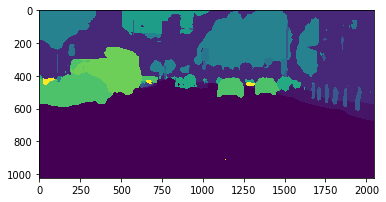

In [ ]:
from PIL import Image
from torchvision import transforms
import numpy as np
import shutil
import matplotlib.pyplot as plt


# code to get predicted masks and upload to root folder


#root = "/content/drive/MyDrive/multiclass-seg/cityscapes"
imagePath = "/content/drive/MyDrive/multiclass-seg/cityscapes/stuttgart_00" 


#cityPath = imagePath + "/" + city
for image in os.listdir(imagePath):
  path = imagePath + "/" + image
  img = Image.open(path)
  img = transforms.ToTensor()(img)
  img = img.unsqueeze(0)
  img = img.to("cuda")
  pred = icnet_temp(img)[0][0]
  pred = pred.cpu().detach().numpy()
  scores_matrix = pred.argmax(axis=0)
  scores_matrix = scores_matrix.astype(np.uint8)

  final_image = plt.imshow(scores_matrix, interpolation='nearest')
  #final_image = Image.fromarray(scores_matrix).convert('RGB')

  img_path = "/content/drive/MyDrive/multiclass-seg/demo_video_pred_masks/" + image

  plt.savefig(img_path + image)
  #final_image.save(img_path)
  #save_to_drive_file(img_path)